Dataset loaded successfully!
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0    

,male_original,age_original,education_original,currentSmoker_original,cigsPerDay_original,BPMeds_original,prevalentStroke_original,prevalentHyp_original,diabetes_original,totChol_original,...,BPMeds_anon,prevalentStroke_anon,prevalentHyp_anon,diabetes_anon,totChol_anon,sysBP_anon,diaBP_anon,BMI_anon,heartRate_anon,glucose_anon
3002,1,38,1.0,1,30.0,0.0,0,0,0,281.0,...,0.0,0.0,0.5,0.5,276.5,123.5,81.0,25.635,102.5,84.0
863,1,39,2.0,0,0.0,0.0,0,0,0,247.0,...,0.0,0.0,0.0,0.0,241.5,118.0,79.5,24.615,90.0,83.5
2654,1,53,3.0,1,20.0,0.0,0,1,0,204.0,...,0.0,0.0,0.5,0.0,194.0,152.5,88.0,31.465,89.0,90.0
363,0,45,2.0,0,0.0,0.0,0,1,0,304.0,...,0.5,0.0,0.5,0.0,295.5,144.5,95.0,28.120,90.5,74.5
704,0,47,2.0,1,10.0,0.0,0,0,0,191.0,...,0.0,0.0,0.5,0.0,193.5,128.5,82.0,22.880,62.5,81.5


Anonymized training data scaled with the SAME scaler as the real baseline.


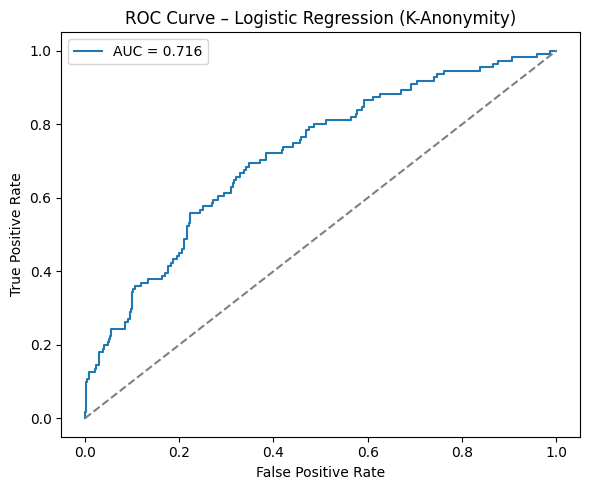

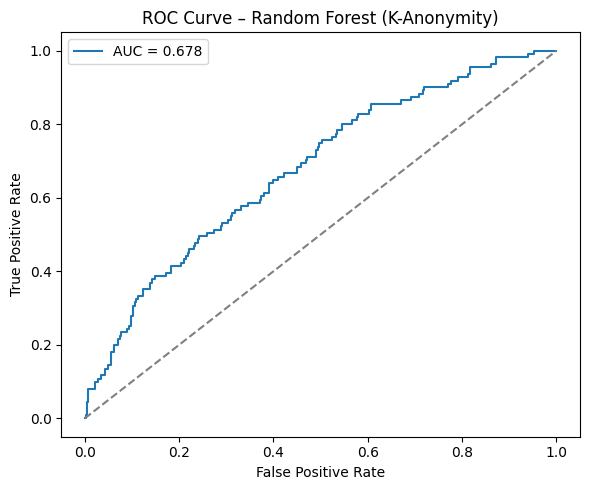

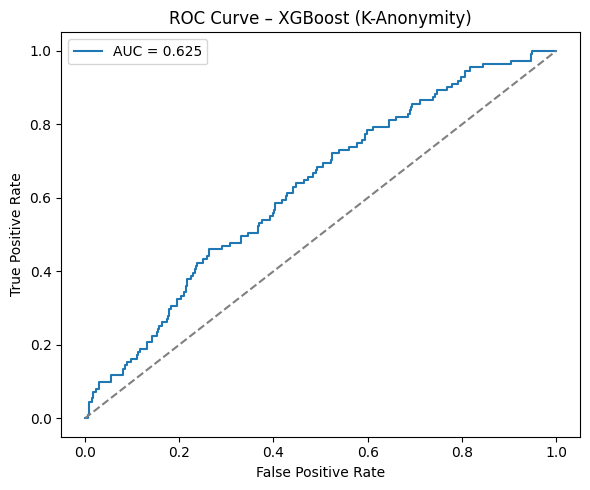


AUC results on REAL test set (trained on K-Anonymous data):
Logistic Regression: 0.7157
Random Forest: 0.6780
XGBoost: 0.6250

📁 Saved K-Anonymity results for method 'kanon' to ../data/results/model_results.csv (no duplicates).

=== REAL vs K-ANONYMITY AUC Comparison ===


method,kanon,real
model,,
Logistic Regression,0.715672,0.724580
Random Forest,0.677968,0.703472
XGBoost,0.624973,0.719299


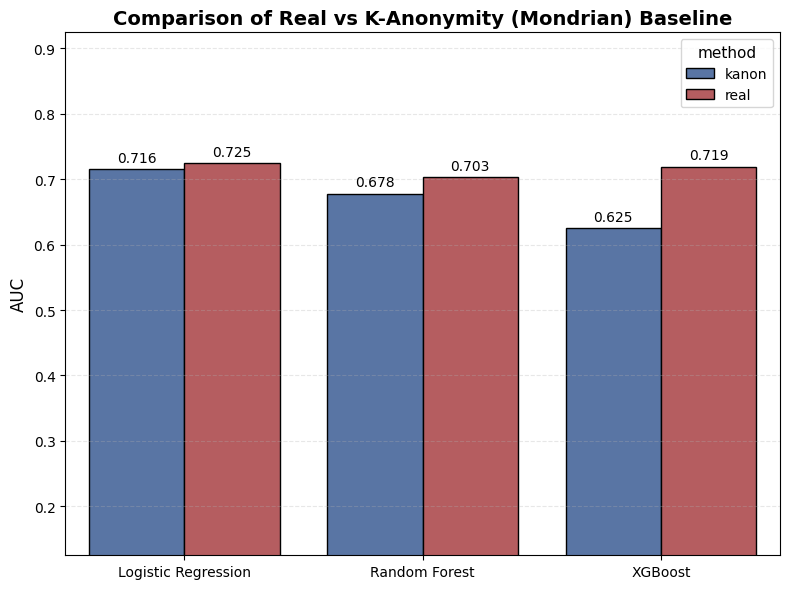


=== INTERPRETATION OF K-ANONYMITY (MONDRIAN) RESULTS ===

1. Limited performance degradation:
   The AUC scores for models trained on the k-anonymized dataset remain close to the real baseline.
   Logistic Regression and Random Forest show only small decreases (~0.01–0.03 AUC),
   while XGBoost experiences a more pronounced drop (~0.09 AUC).
   This indicates that Mondrian preserves the essential predictive structure of the dataset,
   while smoothing out fine-grained details.

2. Model ranking is largely preserved:
   Logistic Regression maintains performance closest to the real baseline,
   followed by Random Forest, while XGBoost is most affected.
   The stability in model ordering suggests that Mondrian maintains the problem’s
   underlying statistical relationships.

3. Effect of Mondrian generalization:
   Mondrian replaces quasi-identifiers with group-level generalized values, reducing granularity.
   This smoothing tends to benefit linear models but weakens models like XGBoost

In [2]:
#!/usr/bin/env python
# coding: utf-8

# --- NOTEBOOK 04: K-ANONYMITY (MONDRIAN) BASELINE ---
# Goal:
# - Apply k-anonymity (Mondrian-style) on the REAL TRAIN set
# - Train Logistic Regression, Random Forest, XGBoost on k-anonymous data
# - Evaluate on the SAME REAL TEST set as in Notebook 02 and 03
# - Save results to ../data/results/model_results.csv with method = "kanon"
# - Generate ROC curves and AUC comparison (Real vs K-Anonymity)
#
# NOTE: Interpretations will be added later after seeing actual AUCs.

# ------------------------------------------------------
# 1. Imports
# ------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import os
import warnings
warnings.filterwarnings("ignore")


# ------------------------------------------------------
# 2. Load cleaned dataset
# ------------------------------------------------------
file_path = "../data/processed/framingham_clean.csv"
df = pd.read_csv(file_path)

print("Dataset loaded successfully!")
print(df.head())

target = "TenYearCHD"
X = df.drop(columns=[target])
y = df[target]

# Numeric columns (same logic as Notebook 2 / 3)
numerical_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

print(f"Number of features: {X.shape[1]}")
print(f"Numeric columns: {numerical_cols}")


# ------------------------------------------------------
# 3. Train/Test split (must match Notebook 02 / 03)
# ------------------------------------------------------
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train_real.shape}, Test shape: {X_test_real.shape}")


# ------------------------------------------------------
# 4. Scaling (fit ONLY on REAL train, as in baseline + CTGAN)
# ------------------------------------------------------
scaler = MinMaxScaler()

X_train_real_scaled = X_train_real.copy()
X_test_real_scaled = X_test_real.copy()

X_train_real_scaled[numerical_cols] = scaler.fit_transform(X_train_real[numerical_cols])
X_test_real_scaled[numerical_cols] = scaler.transform(X_test_real[numerical_cols])

print("Scaling fitted on REAL training data and applied to train/test.")


# ------------------------------------------------------
# 5. Mondrian-style K-Anonymity implementation
# ------------------------------------------------------
# We implement a simple top-down Mondrian partitioning:
# - Start with all records in one partition
# - Recursively split partitions along the attribute with largest range
# - Stop splitting when a partition has < 2k or cannot be split without violating k

def mondrian_partition(df_part, quasi_cols, k):
    """Return a list of index arrays (partitions) using a simple Mondrian algorithm."""
    partitions = [df_part.index]
    final_partitions = []

    while partitions:
        idx = partitions.pop()
        subset = df_part.loc[idx, quasi_cols]

        # If too small to split into two groups of at least k, stop
        if len(idx) < 2 * k:
            final_partitions.append(idx)
            continue

        # Compute spans (range) for each quasi-identifier
        spans = subset.max() - subset.min()

        # If all spans are zero (constant), cannot split
        if (spans <= 0).all():
            final_partitions.append(idx)
            continue

        # Choose attribute with max span
        split_col = spans.idxmax()

        # Split by median
        median_val = subset[split_col].median()
        left_idx = subset[subset[split_col] <= median_val].index
        right_idx = subset[subset[split_col] > median_val].index

        # If either side would violate k, stop splitting
        if len(left_idx) < k or len(right_idx) < k:
            final_partitions.append(idx)
            continue

        # Otherwise, keep splitting both sides
        partitions.append(left_idx)
        partitions.append(right_idx)

    return final_partitions


def apply_mondrian_k_anonymity(df_part, quasi_cols, k):
    """Apply Mondrian k-anonymity and return a generalized DataFrame."""
    partitions = mondrian_partition(df_part, quasi_cols, k)
    anon_df = df_part.copy()

    for idx in partitions:
        sub = df_part.loc[idx, quasi_cols]
        for col in quasi_cols:
            low = sub[col].min()
            high = sub[col].max()
            generalized_value = (low + high) / 2.0
            anon_df.loc[idx, col] = generalized_value

    return anon_df


# ------------------------------------------------------
# 6. Apply K-Anonymity (k=5) on REAL training data (UNSCALED)
# ------------------------------------------------------
k = 5
quasi_cols = numerical_cols  # we generalize all numeric columns

print(f"Applying Mondrian K-Anonymity with k={k} on training data...")

X_train_anon = apply_mondrian_k_anonymity(X_train_real, quasi_cols, k)

print("K-Anonymity (Mondrian) applied on training data.")
print("Example (before vs after) for the first rows:")
display(pd.concat([
    X_train_real[quasi_cols].head().add_suffix("_original"),
    X_train_anon[quasi_cols].head().add_suffix("_anon")
], axis=1))


# ------------------------------------------------------
# 7. Scale the ANONYMIZED training data using the SAME scaler
# ------------------------------------------------------
X_train_anon_scaled = X_train_anon.copy()
X_train_anon_scaled[numerical_cols] = scaler.transform(X_train_anon[numerical_cols])

print("Anonymized training data scaled with the SAME scaler as the real baseline.")


# ------------------------------------------------------
# 8. Utility: ROC plot
# ------------------------------------------------------
def plot_roc(label, y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve – {label}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------
# 9. Train models on K-Anonymous data → Evaluate on REAL test
# ------------------------------------------------------
results_kanon = {}

# Logistic Regression
log_clf = LogisticRegression(max_iter=500, solver="lbfgs", class_weight="balanced")
log_clf.fit(X_train_anon_scaled, y_train_real)
log_pred = log_clf.predict_proba(X_test_real_scaled)[:, 1]
auc_log_kanon = roc_auc_score(y_test_real, log_pred)
results_kanon["Logistic Regression"] = auc_log_kanon
plot_roc("Logistic Regression (K-Anonymity)", y_test_real, log_pred)

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight="balanced",
    random_state=42
)
rf_clf.fit(X_train_anon_scaled, y_train_real)
rf_pred = rf_clf.predict_proba(X_test_real_scaled)[:, 1]
auc_rf_kanon = roc_auc_score(y_test_real, rf_pred)
results_kanon["Random Forest"] = auc_rf_kanon
plot_roc("Random Forest (K-Anonymity)", y_test_real, rf_pred)

# XGBoost
xgb_clf = xgb.XGBClassifier(
    eval_metric="logloss",
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=2,
    random_state=42
)
xgb_clf.fit(X_train_anon_scaled, y_train_real)
xgb_pred = xgb_clf.predict_proba(X_test_real_scaled)[:, 1]
auc_xgb_kanon = roc_auc_score(y_test_real, xgb_pred)
results_kanon["XGBoost"] = auc_xgb_kanon
plot_roc("XGBoost (K-Anonymity)", y_test_real, xgb_pred)

print("\nAUC results on REAL test set (trained on K-Anonymous data):")
for k_model, v in results_kanon.items():
    print(f"{k_model}: {v:.4f}")


# ------------------------------------------------------
# 10. Save K-Anonymity results to model_results.csv (no duplicates)
# ------------------------------------------------------
results_path = "../data/results/model_results.csv"
method_name = "kanon"

results_df = pd.DataFrame([
    {"method": method_name, "model": "Logistic Regression", "auc": results_kanon["Logistic Regression"]},
    {"method": method_name, "model": "Random Forest", "auc": results_kanon["Random Forest"]},
    {"method": method_name, "model": "XGBoost", "auc": results_kanon["XGBoost"]},
])

if os.path.exists(results_path):
    master = pd.read_csv(results_path)
    # Remove any previous rows for this method
    master = master[master["method"] != method_name]
    master = pd.concat([master, results_df], ignore_index=True)
else:
    master = results_df

master.to_csv(results_path, index=False)
print(f"\n📁 Saved K-Anonymity results for method '{method_name}' to {results_path} (no duplicates).")


# ------------------------------------------------------
# 11. Load REAL baseline and compare REAL vs K-Anonymity
# ------------------------------------------------------
df_results = pd.read_csv(results_path)
# Keep only real baseline and kanon for this comparison
df_results = df_results[df_results["method"].isin(["real", "kanon"])]

# Ensure one row per (method, model)
df_results = df_results.drop_duplicates(subset=["method", "model"], keep="last")

comparison = df_results.pivot(index="model", columns="method", values="auc")

print("\n=== REAL vs K-ANONYMITY AUC Comparison ===")
display(comparison)

# Nice bar plot
plt.figure(figsize=(8, 6))

comparison_plot = (
    comparison.reset_index()
              .melt(id_vars="model", value_name="auc", var_name="method")
)

sns.barplot(
    data=comparison_plot,
    x="model",
    y="auc",
    hue="method",
    palette=["#4C72B0", "#C44E52"],  # Real = blue, K-Anon = red-ish
    edgecolor="black"
)

# Add labels above bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.3f", padding=3)

plt.title("Comparison of Real vs K-Anonymity (Mondrian) Baseline", fontsize=14, weight="bold")
plt.xlabel("")
plt.ylabel("AUC", fontsize=12)

plt.ylim(
    comparison_plot["auc"].min() - 0.5,
    comparison_plot["auc"].max() + 0.2
)

plt.legend(title="method", fontsize=10, title_fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 12. Interpretation (print-only version for the notebook)
# ------------------------------------------------------

print("\n=== INTERPRETATION OF K-ANONYMITY (MONDRIAN) RESULTS ===\n")

print("1. Limited performance degradation:")
print("   The AUC scores for models trained on the k-anonymized dataset remain close to the real baseline.")
print("   Logistic Regression and Random Forest show only small decreases (~0.01–0.03 AUC),")
print("   while XGBoost experiences a more pronounced drop (~0.09 AUC).")
print("   This indicates that Mondrian preserves the essential predictive structure of the dataset,\n"
      "   while smoothing out fine-grained details.\n")

print("2. Model ranking is largely preserved:")
print("   Logistic Regression maintains performance closest to the real baseline,")
print("   followed by Random Forest, while XGBoost is most affected.")
print("   The stability in model ordering suggests that Mondrian maintains the problem’s\n"
      "   underlying statistical relationships.\n")

print("3. Effect of Mondrian generalization:")
print("   Mondrian replaces quasi-identifiers with group-level generalized values, reducing granularity.")
print("   This smoothing tends to benefit linear models but weakens models like XGBoost")
print("   that depend on precise threshold splits.\n")

print("4. Implications for privacy-preserving ML:")
print("   K-anonymity via Mondrian achieves a strong privacy–utility balance.")
print("   It protects identity while preserving useful signal for downstream ML tasks.")
print("   The consistent behavior across models makes it a reliable anonymization solution.\n")

print("Overall conclusion:")
print("   Mondrian K-Anonymity provides good utility retention with predictable degradation.")
print("   It preserves model trends and general structure, making it suitable for privacy-preserving\n"
      "   workflows where moderate anonymization is acceptable.")
